In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import keras
from keras import layers 
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential 
import sys
import os
import h5py 
import tensorflow as tf
from tqdm import tqdm
import random
from scipy import stats

def load_sca_model(model_file):
    try:
        model = load_model(model_file)
    except:
        print("Error: can't load Keras model file '%s'" % model_file)
        sys.exit(-1)
    return model

In [5]:
#S盒
AES_Sbox = np.array([
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
            ])

In [6]:
def get_prediction(model, Traces):
    input_layer_shape = model.input_shape
    input_data = Traces.reshape((Traces.shape[0],) + input_layer_shape[1:])
    predictions = model.predict(input_data, verbose=0)
    return predictions

In [7]:
def rank_cal(selected_probabilities, key_interest, num_trace):
    rank = []
    total_pro = np.zeros(256)

    for i in range(num_trace):
        total_pro += np.log(selected_probabilities[i] + 1e-12)
        sorted_proba = np.array(list(map(lambda a: total_pro[a], total_pro.argsort()[::-1])))
        real_key_rank = np.where(sorted_proba == total_pro[key_interest])[0][0]
        rank.append(real_key_rank)
    rank = np.array(rank)

    return rank

In [8]:
def prediction_to_probability(selected_cts_interest, selected_predictions, num_trace):
    
    probabilities_array = []
    
    for i in range(num_trace):
        probabilities=np.zeros(256)
        for j in range(256):
            sbox_out= selected_cts_interest[i]^j
            value = sbox_out
            probabilities[j] = selected_predictions[i][value]
        probabilities_array.append(probabilities)
    probabilities_array = np.array(probabilities_array)

    for i in range(len(probabilities_array)):
        if np.count_nonzero(probabilities_array[i]) != 256:
            none_zero_predictions = [a for a in probabilities_array[i] if a != 0]
            min_v = min(none_zero_predictions)
            probabilities_array[i] = probabilities_array[i] + min_v**2	
    
    return probabilities_array

In [9]:
def pge_test(model, Traces, key_interest, cts_interest, num_trace, average, plot_on=False):
    
    predictions = get_prediction(model, Traces)

    ranks_array = []

    for pge in tqdm(range(average)):
        select = random.sample(range(len(Traces)), num_trace)
        selected_cts_interest = cts_interest[select]
        selected_predictions = predictions[select]
        
        probabilities = prediction_to_probability(selected_cts_interest, selected_predictions, num_trace)
        ranks = rank_cal(probabilities, key_interest, num_trace)
        ranks_array.append(ranks)

    ranks_array = np.array(ranks_array)

    for pge_1 in range(ranks_array.shape[1]):
        if np.count_nonzero(ranks_array[:, pge_1]) < int(average* 0.5):
            #print(pge_1+1)
            break
    
    average_ranks = np.sum(ranks_array, axis=0) / average
    #pge_2 = np.where(average_ranks == 0)[0][0]
    
    if plot_on:
        plt.figure()
        plt.plot(average_ranks)
        plt.xlabel('Number of Traces')
        plt.ylabel('PGE')
        plt.show()

    return pge_1+1

In [10]:
def load_traces(T_path,C_path,K_path, interest_byte=0):    

    traces = np.load(T_path)
    ct_name = np.load(C_path)      
    key_name = np.load(K_path)  
    key = key_name.astype(int)
    ct = ct_name.astype(int)

    
    label=np.bitwise_xor(ct[:,interest_byte],key[:,interest_byte])
    indices = np.arange(label.shape[0]) 
    
    #np.random.shuffle(indices)
    label = label[indices]
    traces = traces[indices, :]
    
    return traces, ct, key, label

In [11]:
def snr(x, y):               
    mean_tmp = []
    var_tmp = []                           
    for i in np.unique(y):                 
        index = np.where(y == i)[0]        
        mean_tmp.append(np.mean(x[index, :], axis=0))
        var_tmp.append(np.var(x[index,:], axis=0))
    snr = np.var(mean_tmp, axis=0) / np.mean(var_tmp, axis=0)
    return snr

In [12]:
def SNR(traces,ct,key, interest_byte=0, plot_on=False):
    
    #labels = np.zeros(key.shape)
    labels=(ct^key)
    byte = snr(traces,labels[:,interest_byte])
    snr_value=np.max(np.absolute(byte))
    #font = {'family' : 'Times New Roman','weight' : 'normal','size'   : 20,}
    if plot_on:
        plt.figure(figsize = (6, 2))   
        plt.plot(byte,)
        plt.xlabel('Sample', fontdict={'family': 'Times New Roman', 'size': 8})
        plt.ylabel('SNR', fontdict={'family': 'Times New Roman', 'size': 8})
        #print("the point which has the maximum SNR:", np.argmax(np.absolute(byte_1)))
        #print("the maximum SNR value:", snr_value)
    #print(labels)
    return snr_value, labels

In [13]:
def HammingWeight(input_data):
    #=======================================================
    #HammingWeight(）：计算输入数据的汉明重量。
    #-----------------------------------------------------
    #函数的输入：
    #input_data: 需要被计算的数据
    #------------------------------------------------------
    #函数的输出
    #=======================================================
    output_data = np.zeros(input_data.shape)
    
    for data_num in range(len(output_data)):
        while input_data[data_num]:
            output_data[data_num] += input_data[data_num]%2
            input_data[data_num] = int(input_data[data_num]/2)
    output = output_data.reshape(input_data.shape)
    return output

In [14]:
def ttest(traces,labels_input,interest_byte=0,plot_on=False):    
    num_trace = trace.shape[0]
    Labels = HammingWeight(labels_input[:, interest_byte])
    Traces = traces[range(num_trace), :]
    Labels = Labels[range(num_trace)]



    #permutation = np.random.RandomState(seed=42).permutation(range(Traces_train.shape[0]))

    index_1 = np.where(Labels > 4)
    index_2 = np.where(Labels < 4)

    index_1 = np.array(index_1)[0]
    index_2 = np.array(index_2)[0]
    (statistic, pvalue) = stats.ttest_ind(Traces[index_1, :],
                                         Traces[index_2, :])  # , equal_var=False)
    tvalue = np.max(np.absolute(statistic))
    
    if plot_on:
        plt.figure(figsize = (6, 2)) 
        #print("the point which has the maximum T-value:", np.argmax(np.absolute(statistic)))
        #print("the maximum T-value:", np.max(np.absolute(statistic)))
        plt.plot(np.absolute(statistic))
        plt.xlabel('Sample', fontdict={'family': 'Times New Roman', 'size': 8})
        plt.ylabel('SOST value', fontdict={'family': 'Times New Roman', 'size': 8})

    return tvalue

[[ 46 239  21 ...  32 146   4]
 [ 91  57 234 ...  88 123 227]
 [ 73 125  74 ... 198 120 179]
 ...
 [ 10 117 161 ... 126 152 140]
 [225  91 191 ... 104 107 158]
 [233 136 160 ...   4 132 106]]
[[ 46 239  21 ...  32 146   4]
 [ 91  57 234 ...  88 123 227]
 [ 73 125  74 ... 198 120 179]
 ...
 [ 10 117 161 ... 126 152 140]
 [225  91 191 ... 104 107 158]
 [233 136 160 ...   4 132 106]]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.45it/s]


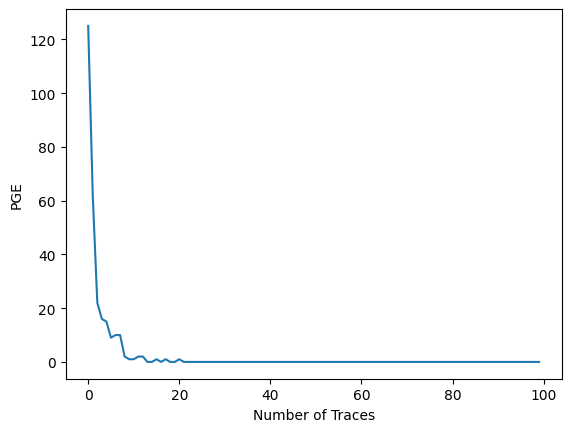

snr_value: 3.4068, tvalue: 2.8174, Acc: 0.0110, PGE: 100.0
===========DONE==========


In [16]:
#侧信道数据路径
T_path="Data_CN\\Data\\0m_9174_1k-1\\100_traces_maxmin.npy"
C_path="Data_CN\\Data\\0m_9174_1k-1\\100_ct.npy"
K_path="Data_CN\\Data\\0m_9174_1k-1\\100_10th_roundkey.npy"
model_path ="Data_SE\\model\\cnn_model-20input.h5"
num_trace = 100
num_pge_test=1

model = load_model(model_path)
trace, ct, key, label_0 = load_traces(T_path,C_path,K_path, interest_byte=0)
key_interest = key[0,0]
cts_interest = ct[:,0]
trace = trace[:, 200:220]


snr_value, labels = SNR(trace, ct, key, interest_byte=0, plot_on=False)
print(labels)
labels_test = labels
tvalue = ttest(trace, labels_test, interest_byte=0, plot_on=False)
print(labels)
accuracy = model.evaluate(trace, to_categorical(label_0, num_classes=256),verbose=0)
pge_1 = pge_test(model, trace, key_interest, cts_interest, num_trace, average=num_pge_test, plot_on=True)

print(f"snr_value: {snr_value:.4f}, tvalue: {tvalue:.4f}, Acc: {accuracy[1]:.4f}, PGE: {pge_1:.1f}")   
print("===========DONE==========")

In [46]:
label_0

array([ 94,  72, 203, ...,  78, 229,  91])

In [22]:
ct

array([[104,  56,  92, ..., 240, 107, 160],
       [126, 100, 198, ..., 116, 223,  48],
       [253,  65,  13, ...,   4, 175, 194],
       ...,
       [120,  33,  31, ..., 112, 183, 252],
       [211,  96,  32, ...,  49, 226, 238],
       [109, 252,  73, ..., 144, 103,  65]])

In [23]:
key

array([[ 54, 208,  36, ..., 186, 182, 187],
       [ 54, 208,  36, ..., 186, 182, 187],
       [ 54, 208,  36, ..., 186, 182, 187],
       ...,
       [ 54, 208,  36, ..., 186, 182, 187],
       [ 54, 208,  36, ..., 186, 182, 187],
       [ 54, 208,  36, ..., 186, 182, 187]])

In [24]:
test = ct ^ key

In [25]:
test

array([[ 94, 232, 120, ...,  74, 221,  27],
       [ 72, 180, 226, ..., 206, 105, 139],
       [203, 145,  41, ..., 190,  25, 121],
       ...,
       [ 78, 241,  59, ..., 202,   1,  71],
       [229, 176,   4, ..., 139,  84,  85],
       [ 91,  44, 109, ...,  42, 209, 250]])

Text(0, 0.5, 'SOST value')

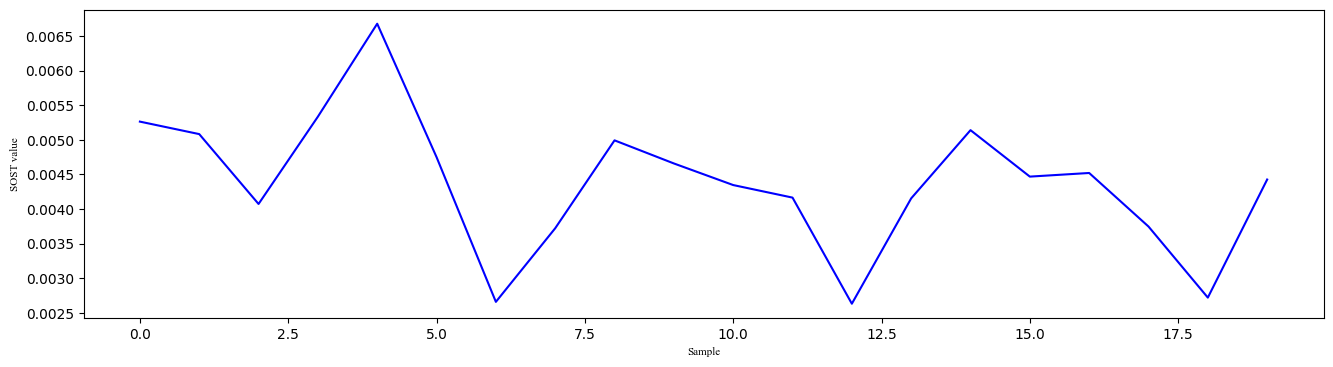

In [14]:
#侧信道数据路径
T_path="Data_FW\\Data\\12m_9174_11k-1\\100_traces.npy"
C_path="Data_FW\\Data\\12m_9174_11k-1\\100_ct.npy"
K_path="Data_FW\\Data\\12m_9174_11k-1\\100_10th_roundkey.npy"

trace, ct, key, label_0 = load_traces(T_path,C_path,K_path)
key_interest = key[0,0]
cts_interest = ct[:,0]
trace = trace[:, 200:220]
plt.figure(figsize = (16, 4)) 
#print("the point which has the maximum T-value:", np.argmax(np.absolute(statistic)))
#print("the maximum T-value:", np.max(np.absolute(statistic)))
plt.plot(trace[1], color='b')
plt.xlabel('Sample', fontdict={'family': 'Times New Roman', 'size': 8})
plt.ylabel('SOST value', fontdict={'family': 'Times New Roman', 'size': 8})

In [19]:
ct

array([[104,  56,  92, ..., 240, 107, 160],
       [126, 100, 198, ..., 116, 223,  48],
       [253,  65,  13, ...,   4, 175, 194],
       ...,
       [120,  33,  31, ..., 112, 183, 252],
       [211,  96,  32, ...,  49, 226, 238],
       [109, 252,  73, ..., 144, 103,  65]])

In [20]:
key

array([[ 54, 208,  36, ..., 186, 182, 187],
       [ 54, 208,  36, ..., 186, 182, 187],
       [ 54, 208,  36, ..., 186, 182, 187],
       ...,
       [ 54, 208,  36, ..., 186, 182, 187],
       [ 54, 208,  36, ..., 186, 182, 187],
       [ 54, 208,  36, ..., 186, 182, 187]])